In [2]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes
## for statistical tests
import scipy
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular
import matplotlib.ticker as plticker
import pickle
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
#Predit on the test set
dfs = pd.read_csv("train.csv")
dfs.head()

,Id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Category
0,3222,1,1,1,14,1,1,1,13,28,...,0,6,7,6,14.714286,0,11.1,0.6,2.02,Graduate
1,2388,1,8,4,9,1,1,1,23,14,...,0,5,10,2,12.500000,0,11.1,0.6,2.02,Dropout
2,1865,1,12,1,17,0,1,1,1,1,...,0,5,5,5,12.400000,0,15.5,2.8,-4.06,Graduate
3,652,1,12,1,12,1,12,1,1,5,...,0,8,11,7,12.614286,0,12.7,3.7,-1.70,Graduate
4,4220,1,1,1,14,1,1,1,19,28,...,0,5,5,0,0.000000,0,9.4,-0.8,-3.12,Dropout


In [4]:
#ENCODING
dfs = pd.get_dummies(dfs, columns=['Marital status'])
dfs = pd.get_dummies(dfs, columns=['Application mode'])
dfs = pd.get_dummies(dfs, columns=['Course'])
dfs = pd.get_dummies(dfs, columns=['Previous qualification'])
dfs = pd.get_dummies(dfs, columns=['Nacionality'])
dfs = pd.get_dummies(dfs, columns=["Mother's occupation"])
dfs = pd.get_dummies(dfs, columns=["Father's occupation"])

#DROP AND CREATE
dfs = dfs.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfs["valid_enroll_sem2"] = dfs["Curricular units 2nd sem (enrolled)"] - dfs["Curricular units 2nd sem (approved)"]
dfs["valid_enroll_sem1"] = dfs["Curricular units 1st sem (enrolled)"] - dfs["Curricular units 1st sem (approved)"]
dfs["gap_enroll_valid"] = dfs["valid_enroll_sem1"] - dfs["valid_enroll_sem2"]


#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfs.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfs.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfs["Category"]
dtf_scaled["Id"] = dfs["Id"]
dfs = dtf_scaled

#features selection
df = dfs[["Id", "Curricular units 2nd sem (approved)", "valid_enroll_sem2", "valid_enroll_sem1", "gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10", "Mother's occupation_1", "Father's occupation_12", "Father's occupation_1",
"Displaced", "Category"]]

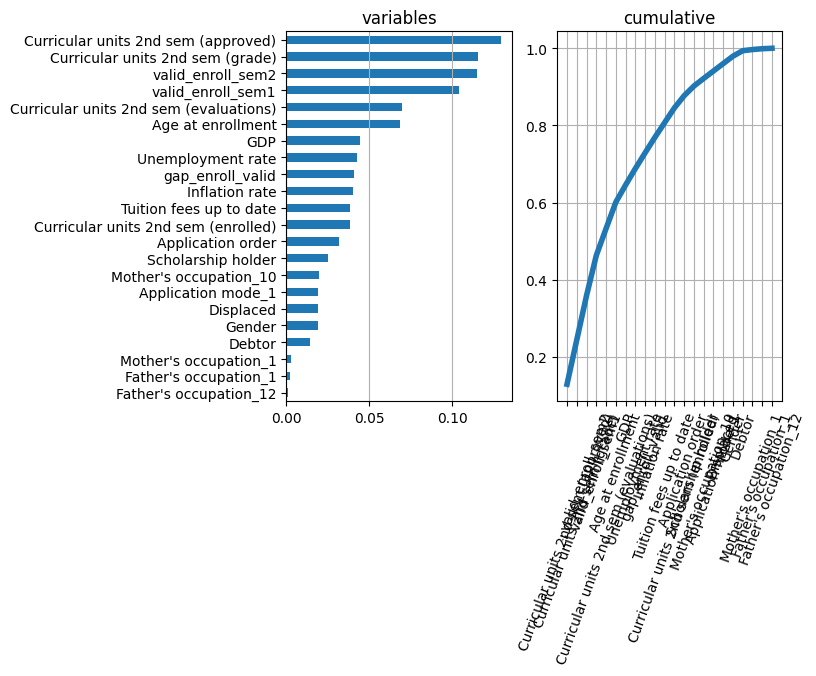

,IMPORTANCE,cumsum
VARIABLE,,
Curricular units 2nd sem (approved),0.129134,0.129134
Curricular units 2nd sem (grade),0.115050,0.244184
valid_enroll_sem2,0.114878,0.359063
valid_enroll_sem1,0.103934,0.462997
Curricular units 2nd sem (evaluations),0.069581,0.532577
Age at enrollment,0.068412,0.600990
GDP,0.044553,0.645542
Unemployment rate,0.042539,0.688081
gap_enroll_valid,0.040835,0.728916


In [5]:
# Plot
X = df.drop(["Category", "Id"], axis=1).values
y = df["Category"].values
feature_names = df.drop(["Category", "Id"], axis=1).columns

model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
dfs_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False).nlargest(30,"IMPORTANCE")
dfs_importances['cumsum'] = dfs_importances['IMPORTANCE'].cumsum(axis=0)
dfs_importances = dfs_importances.set_index("VARIABLE")
    
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].title.set_text('variables')
dfs_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dfs_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dfs_importances)), xticklabels=dfs_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()
dfs_importances.head(30)

<AxesSubplot: xlabel='selection', ylabel='features'>

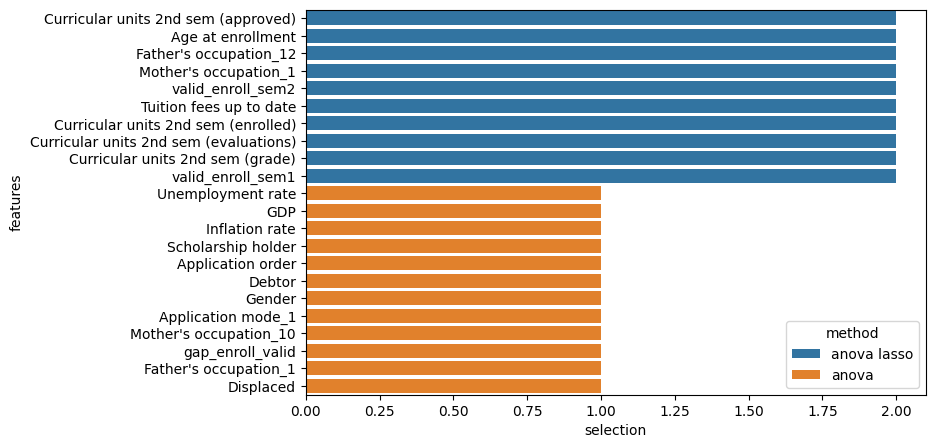

In [6]:
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k="all").fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(8,5))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

Text(0.5, 1.0, 'pearson correlation')

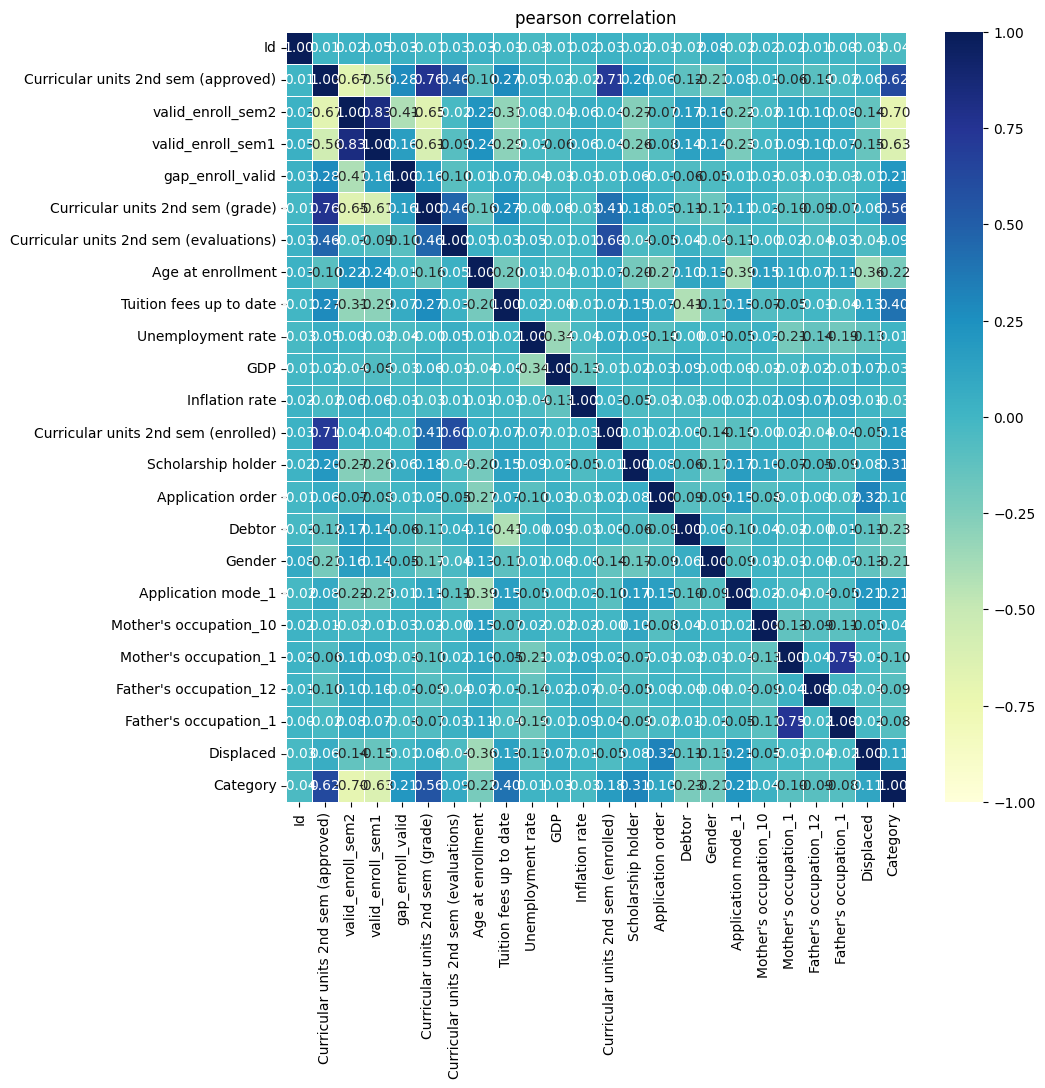

In [7]:
corr_matrix = df.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [10]:
X_names = ["Curricular units 2nd sem (approved)", "valid_enroll_sem2", "valid_enroll_sem1", "gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10", "Mother's occupation_1", "Father's occupation_12", "Father's occupation_1",
"Displaced"
]

X_train = dfs[X_names].values
y_train = dfs["Category"]
y_train = y_train.replace(['Dropout', 'Enrolled', 'Graduate'],[0,1,2]).values

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [11]:
filename = 'finalized_model_academic_V4bis.sav'
pickle.dump(model, open(filename, 'wb'))

In [12]:
# validation

dfv = pd.read_csv("validation.csv")
#ENCODING
dfv = pd.get_dummies(dfv, columns=['Marital status'])
dfv = pd.get_dummies(dfv, columns=['Application mode'])
dfv = pd.get_dummies(dfv, columns=['Course'])
dfv = pd.get_dummies(dfv, columns=['Previous qualification'])
dfv = pd.get_dummies(dfv, columns=['Nacionality'])
dfv = pd.get_dummies(dfv, columns=["Mother's occupation"])
dfv = pd.get_dummies(dfv, columns=["Father's occupation"])

#DROP AND CREATE
dfv = dfv.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfv["valid_enroll_sem2"] = dfv["Curricular units 2nd sem (enrolled)"] - dfv["Curricular units 2nd sem (approved)"]
dfv["valid_enroll_sem1"] = dfv["Curricular units 1st sem (enrolled)"] - dfv["Curricular units 1st sem (approved)"]
dfv["gap_enroll_valid"] = dfv["valid_enroll_sem1"] - dfv["valid_enroll_sem2"]

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfv.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfv.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfv["Category"]
dtf_scaled["Id"] = dfv["Id"]
dfv = dtf_scaled

#features selection
dfv = dfv[["Id", "Curricular units 2nd sem (approved)", "valid_enroll_sem2", "valid_enroll_sem1", "gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10", "Mother's occupation_1", "Father's occupation_12", "Father's occupation_1",
"Displaced", "Category"]]

#Validation score see

X_validation = dfv[["Curricular units 2nd sem (approved)", "valid_enroll_sem2", "valid_enroll_sem1", "gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Curricular units 2nd sem (evaluations)",
"Age at enrollment",
"Tuition fees up to date",
"Unemployment rate",
"GDP",
"Inflation rate",
"Curricular units 2nd sem (enrolled)",
"Scholarship holder",
"Application order",
"Debtor",
"Gender",
"Application mode_1",
"Mother's occupation_10", "Mother's occupation_1", "Father's occupation_12", "Father's occupation_1",
"Displaced"]].values
y_validation = dfv["Category"]
y_validation = y_validation.replace(['Dropout', 'Enrolled', 'Graduate'],[0,1,2]).values

loaded_model = pickle.load(open("finalized_model_academic_V4bis.sav", 'rb'))

# make predictions for test data
y_pred = model.predict(X_validation)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_validation, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
result = loaded_model.score(X_validation, y_validation)
print(result)

loaded_model = pickle.load(open("finalized_model_academic_V4bis.sav", 'rb'))
result = loaded_model.score(X_validation, y_validation)
print(result)


Accuracy: 76.73%
0.7673192771084337
0.7673192771084337
